<a href="https://colab.research.google.com/github/pattangeumdduck/stack_study_record/blob/main/pubmed_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#목적
한국 의료사태(예: 전공의 파업) 전후의 한국 저자 논문 수 변화를 분석하기 위한 데이터 수집 및 전처리

#내용 요약

PubMed에서 특정 쿼리로 한국 저자 논문을 월별로 자동 수집

2023년 전체와 2024년 4월~2025년 3월 데이터를 추출

월별 논문 수를 데이터프레임으로 저장

이후 분석(평균 비교 등)을 위해 사건 전후 그룹(A집단, B집단)으로 나눔

활용 기술:
Python (Entrez API, Pandas 등)

분석 방향:
사건 전후의 월별 논문 수 평균 비교를 통해 유의미한 차이 검정 (ex. t-test 등)

In [ ]:
!pip install Bio

In [ ]:
from Bio import Entrez
from xml.etree import ElementTree as ET
import pandas as pd
import time
from datetime import datetime, timedelta

Entrez.email = "684259317@naver.com"

In [ ]:
def daterange(start_date, end_date):
    # 1달 단위로 시작 날짜 목록 생성
    dates = []
    current = start_date
    while current <= end_date:
        dates.append(current)
        next_month = (current.replace(day=1) + timedelta(days=32)).replace(day=1)
        current = next_month
    return dates

# PMID 리스트 불러오기 (예: 2024/02/01 ~ 2024/03/29)
def get_pubmed_ids(query, start_date, end_date, retmax=100000):
    date_query = f'("{start_date}"[Date - Publication] : "{end_date}"[Date - Publication])'
    full_query = f'{query} AND {date_query}'
    handle = Entrez.esearch(db="pubmed", term=full_query, retmax=retmax)
    record = Entrez.read(handle)
    return record["IdList"]


# 상세 메타데이터 가져오기
def fetch_pubmed_details(id_list):
    ids = ",".join(id_list)
    handle = Entrez.efetch(db="pubmed", id=ids, retmode="xml")
    records = Entrez.read(handle)
    return records

In [ ]:
#논문 필드 추출 함수 정의
def extract_metadata(records):
    articles = []
    for article in records['PubmedArticle']:
        citation = article['MedlineCitation']
        article_info = citation['Article']

        pmid = citation['PMID']
        title = article_info.get('ArticleTitle', "")
        journal = article_info['Journal']['Title']
        try:
            pub_date = article_info['Journal']['JournalIssue']['PubDate']
            pub_year = pub_date.get('Year', '')
            pub_month = pub_date.get('Month', '01')
            pub_day = pub_date.get('Day', '01')
            pub_date_str = f"{pub_year}-{pub_month}-{pub_day}"
        except:
            pub_date_str = ""

        try:
            mesh_terms = [mh['DescriptorName'] for mh in citation.get('MeshHeadingList', [])]
        except:
            mesh_terms = []

        try:
            pub_type = article_info['PublicationTypeList'][0]
        except:
            pub_type = ""

        articles.append({
            'PMID': str(pmid),
            'Title': title,
            'Journal': journal,
            'PubDate': pub_date_str,
            'Article Type': pub_type,
            'MeSH Terms': ", ".join(str(m) for m in mesh_terms)
        })

    return pd.DataFrame(articles)

In [ ]:
def collect_range(query, start_str, end_str, out_filename):
    start_date = datetime.strptime(start_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_str, "%Y-%m-%d")
    month_starts = daterange(start_date, end_date)

    all_df = []
    monthly_counts = []  # 월별 논문 수를 저장할 리스트
    for i, start in enumerate(month_starts):
        end = (start.replace(day=1) + timedelta(days=32)).replace(day=1) - timedelta(days=1)
        print(f"수집 중: {start.date()} ~ {end.date()}")
        ids = get_pubmed_ids(query, start.strftime("%Y/%m/%d"), end.strftime("%Y/%m/%d"))
        print(f" → {len(ids)}편 검색됨")
        monthly_counts.append(len(ids)) # 월별 논문 수 리스트에 추가
        for j in range(0, len(ids), 200):
            chunk_ids = ids[j:j+200]
            try:
                records = fetch_pubmed_details(chunk_ids)
                df_chunk = extract_metadata(records)
                all_df.append(df_chunk)
            except:
                continue
            time.sleep(1)
    final_df = pd.concat(all_df, ignore_index=True)
    final_df.to_csv(out_filename, index=False)
    print(f"저장 완료: {out_filename}")
    return monthly_counts # 월별 논문 수 리스트 반환

In [ ]:
# 실제 실행
if __name__ == "__main__":
    # 2023 전체
    collect_range("Korea[Affiliation]", "2023-01-01", "2023-12-31", "pubmed_korea_2023.csv")

    # 2024년 4월 ~ 2025년 3월
    collect_range("Korea[Affiliation]", "2024-04-01", "2025-03-31", "pubmed_korea_2024_04_to_2025_03.csv")

📅 수집 중: 2023-01-01 ~ 2023-01-31
 → 8926편 검색됨
📅 수집 중: 2023-02-01 ~ 2023-02-28
 → 4677편 검색됨
📅 수집 중: 2023-03-01 ~ 2023-03-31
 → 5155편 검색됨
📅 수집 중: 2023-04-01 ~ 2023-04-30
 → 4527편 검색됨
📅 수집 중: 2023-05-01 ~ 2023-05-31
 → 4799편 검색됨
📅 수집 중: 2023-06-01 ~ 2023-06-30
 → 4851편 검색됨
📅 수집 중: 2023-07-01 ~ 2023-07-31
 → 4722편 검색됨
📅 수집 중: 2023-08-01 ~ 2023-08-31
 → 4731편 검색됨
📅 수집 중: 2023-09-01 ~ 2023-09-30
 → 4995편 검색됨
📅 수집 중: 2023-10-01 ~ 2023-10-31
 → 5011편 검색됨
📅 수집 중: 2023-11-01 ~ 2023-11-30
 → 5125편 검색됨
📅 수집 중: 2023-12-01 ~ 2023-12-31
 → 5217편 검색됨
✅ 저장 완료: pubmed_korea_2023.csv
📅 수집 중: 2024-04-01 ~ 2024-04-30
 → 4823편 검색됨
📅 수집 중: 2024-05-01 ~ 2024-05-31
 → 4811편 검색됨
📅 수집 중: 2024-06-01 ~ 2024-06-30
 → 4784편 검색됨
📅 수집 중: 2024-07-01 ~ 2024-07-31
 → 5002편 검색됨
📅 수집 중: 2024-08-01 ~ 2024-08-31
 → 4811편 검색됨
📅 수집 중: 2024-09-01 ~ 2024-09-30
 → 5086편 검색됨
📅 수집 중: 2024-10-01 ~ 2024-10-31
 → 5270편 검색됨
📅 수집 중: 2024-11-01 ~ 2024-11-30
 → 5203편 검색됨
📅 수집 중: 2024-12-01 ~ 2024-12-31
 → 5324편 검색됨
📅 수집 중: 2025-01-01 ~ 202

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#파일 불러오기
pubmed_2023 = pd.read_csv("/content/pubmed_project/pubmed_korea_2023.csv")
pubmed_2024 = pd.read_csv("/content/pubmed_project/pubmed_korea_2024_04_to_2025_03.csv")
jcr_2023 = pd.read_excel("/content/pubmed_project/IF_2023.xlsx")
jcr_2024 = pd.read_excel("/content/pubmed_project/IF_2024.xlsx")
# 데이터 전처리: 소문자 변환 및 공백 제거 함수
def clean_journal_name(journal_name):
    if pd.isna(journal_name):
        return ""
    return journal_name.strip().lower()

# 논문 데이터 전처리
pubmed_2023["Clean Journal"] = pubmed_2023["Journal"].apply(clean_journal_name)
pubmed_2024["Clean Journal"] = pubmed_2024["Journal"].apply(clean_journal_name)

# JCR 데이터 전처리
jcr_2023["Clean Journal"] = jcr_2023["Journal name"].apply(clean_journal_name)
jcr_2024["Clean Journal"] = jcr_2024["Name"].apply(clean_journal_name)

# JCR 매핑: 2023년도 논문 → 2022 JIF 부여
pubmed_2023 = pd.merge(pubmed_2023, jcr_2023[["Clean Journal", "2022 JIF"]], on="Clean Journal", how="left")

# JCR 매핑: 2024년도 논문 → 2024 JIF 부여
pubmed_2024 = pd.merge(pubmed_2024, jcr_2024[["Clean Journal", "JIF"]], on="Clean Journal", how="left")

# "JIF" 컬럼을 숫자형으로 변환 (변환 오류 시 NaN 처리)
pubmed_2023["2022 JIF"] = pd.to_numeric(pubmed_2023["2022 JIF"], errors='coerce')
pubmed_2024["JIF"] = pd.to_numeric(pubmed_2024["JIF"], errors='coerce')

# 연도별 평균 Impact Factor 계산
mean_if_2023 = pubmed_2023["2022 JIF"].mean()
mean_if_2024 = pubmed_2024["JIF"].mean()

mean_if_2023, mean_if_2024

(np.float64(5.976497707655661), np.float64(5.314380035276732))

In [4]:
pubmed_2024.head()

,PMID,Title,Journal,PubDate,Article Type,MeSH Terms,Clean Journal,JIF
0,40454126,What is the Reason for the Trend Shift from Dy...,Clinics in orthopedic surgery,2025-Jun-01,Journal Article,"Humans, Retrospective Studies, Hip Fractures, ...",clinics in orthopedic surgery,1.9
1,40226695,Body Weight Variability and Risk of Suicide Mo...,Depression and anxiety,2024-01-01,Journal Article,"Humans, Male, Female, Republic of Korea, Middl...",depression and anxiety,4.7
2,40224815,"Influences of Nursing Professionalism, Empathy...",Journal of nursing management,2024-01-01,Journal Article,"Humans, Cross-Sectional Studies, Empathy, Male...",journal of nursing management,3.7
3,40213347,A comparison of surgical outcomes between outp...,Prostate international,2025-Mar-01,Journal Article,NaN,prostate international,2.7
4,40212122,Low-Temperature Processed Efficient and Reprod...,Small science,2024-Jul-01,Journal Article,NaN,small science,11.1


월별로 IF 지표 평균의 변화 데이터 전처리

In [5]:
# 날짜 형식 변환 및 월 단위 추출
#2024년
pubmed_2024["PubDate"] = pd.to_datetime(pubmed_2024["PubDate"], errors="coerce")
pubmed_2024["PubDate"] = pubmed_2024["PubDate"].dt.to_period("M")
#2023년
pubmed_2023["PubDate"] = pd.to_datetime(pubmed_2023["PubDate"], errors="coerce")
pubmed_2023["PubDate"] = pubmed_2023["PubDate"].dt.to_period("M")

In [6]:
pubmed_2023.head()

,PMID,Title,Journal,PubDate,Article Type,MeSH Terms,Clean Journal,2022 JIF
0,39815928,Parents' perceptions of risk and protective fa...,Journal of intellectual & developmental disabi...,2024-03,Journal Article,"Humans, Male, Female, Republic of Korea, Paren...",journal of intellectual & developmental disabi...,NaN
1,39131557,Regression of Nonalcoholic Fatty Liver Disease...,Gastro hep advances,NaT,Journal Article,NaN,gastro hep advances,NaN
2,39043616,Effectiveness of educational video on standard...,International journal of nursing education sch...,2023-01,Journal Article,"Humans, Nursing Homes, Female, Male, Standardi...",international journal of nursing education sch...,NaN
3,38873009,Comparison of Body Composition Methods for Est...,Canadian prosthetics & orthotics journal,NaT,Journal Article,NaN,canadian prosthetics & orthotics journal,NaN
4,38666123,The aspect of structural connectivity in relat...,Psychoradiology,NaT,Journal Article,NaN,psychoradiology,NaN


In [7]:
pubmed_2024.head()

,PMID,Title,Journal,PubDate,Article Type,MeSH Terms,Clean Journal,JIF
0,40454126,What is the Reason for the Trend Shift from Dy...,Clinics in orthopedic surgery,2025-06,Journal Article,"Humans, Retrospective Studies, Hip Fractures, ...",clinics in orthopedic surgery,1.9
1,40226695,Body Weight Variability and Risk of Suicide Mo...,Depression and anxiety,NaT,Journal Article,"Humans, Male, Female, Republic of Korea, Middl...",depression and anxiety,4.7
2,40224815,"Influences of Nursing Professionalism, Empathy...",Journal of nursing management,NaT,Journal Article,"Humans, Cross-Sectional Studies, Empathy, Male...",journal of nursing management,3.7
3,40213347,A comparison of surgical outcomes between outp...,Prostate international,2025-03,Journal Article,NaN,prostate international,2.7
4,40212122,Low-Temperature Processed Efficient and Reprod...,Small science,2024-07,Journal Article,NaN,small science,11.1


In [8]:
#pubdate 결측치 제거하기(제대로 형식 안 맞추어진 부분)
pubmed_2024 = pubmed_2024.dropna(subset=["PubDate"])
pubmed_2023 = pubmed_2023.dropna(subset=["PubDate"])

len(pubmed_2024)
len(pubmed_2023)

54818

In [13]:
# Impact Factor 열을 숫자형으로 변환
pubmed_2023["2022 JIF"] = pd.to_numeric(pubmed_2023["2022 JIF"], errors="coerce")
pubmed_2024["JIF"] = pd.to_numeric(pubmed_2024["JIF"], errors="coerce")
# 월별 평균 Impact Factor 계산
monthly_if_2023 = pubmed_2023.groupby("PubDate")["2022 JIF"].mean().reset_index()
monthly_if_2023.columns = ["Month", "Average_JIF"]

monthly_if_2024 = pubmed_2024.groupby("PubDate")["JIF"].mean().reset_index()
monthly_if_2024.columns = ["Month", "Average_JIF"]

# 결과 출력
print(monthly_if_2023)

      Month  Average_JIF
0   2022-12          NaN
1   2023-01     6.026308
2   2023-02     6.267888
3   2023-03     6.196195
4   2023-04     6.464079
5   2023-05     6.369662
6   2023-06     6.363097
7   2023-07     6.342393
8   2023-08     6.562922
9   2023-09     6.003716
10  2023-10     6.434590
11  2023-11     6.225855
12  2023-12     6.084970
13  2024-01     6.992585
14  2024-02     6.449647
15  2024-03     6.099183
16  2024-04     5.319048
17  2024-05     5.144068
18  2024-06     5.162651
19  2024-07     3.942857
20  2024-08     7.114286
21  2024-09     3.900000
22  2024-10     5.189474
23  2024-11     3.955000
24  2024-12     4.080000
25  2025-01     2.790000
26  2025-02     3.085714
27  2025-03     2.664286
28  2025-04     3.533333
29  2025-05     2.950000
30  2025-06     3.950000
31  2025-07          NaN


In [14]:
print(monthly_if_2024)

      Month  Average_JIF
0   2023-01     1.300000
1   2024-01     5.100000
2   2024-03     2.850000
3   2024-04     5.226501
4   2024-05     5.691078
5   2024-06     5.169922
6   2024-07     5.574685
7   2024-08     5.662823
8   2024-09     5.526658
9   2024-10     5.714544
10  2024-11     5.549923
11  2024-12     5.164809
12  2025-01     5.754680
13  2025-02     5.457868
14  2025-03     5.600917
15  2025-04     5.962446
16  2025-05     5.739658
17  2025-06     5.412162
18  2025-07     6.537500
19  2025-08     5.100000
20  2025-09     9.120000
21  2025-10     6.733333
22  2025-11     1.500000
23  2025-12     4.647619
24  2026-01     5.900000
25  2026-02     5.900000
26  2026-03     5.900000


데이터 시각화

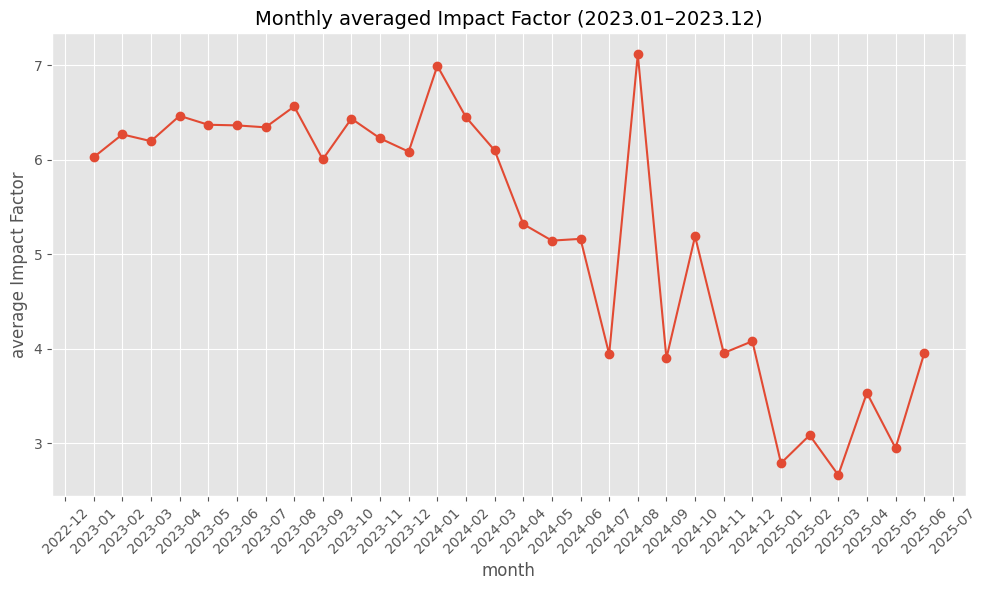

In [18]:
plt.style.use("ggplot")

# 선그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(monthly_if_2023["Month"].astype(str), monthly_if_2023["Average_JIF"], marker='o')

# 제목 및 축 레이블 설정
plt.title("Monthly averaged Impact Factor (2023.01–2023.12)", fontsize=14)
plt.xlabel("month", fontsize=12)
plt.ylabel("average Impact Factor", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

In [19]:
# 필터링 조건 적용
monthly_if_2023 = monthly_if_2023[
    (monthly_if_2023["Month"] >= "2023-01") & (monthly_if_2023["Month"] <= "2023-12")
]

monthly_if_2024 = monthly_if_2024[
    (monthly_if_2024["Month"] >= "2024-04") & (monthly_if_2024["Month"] <= "2025-03")
]


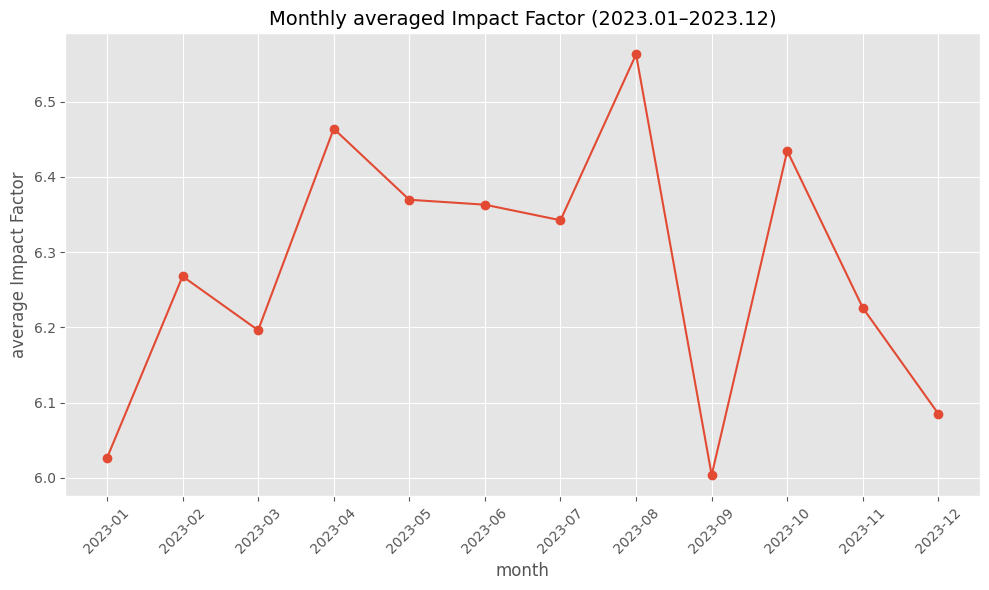

In [20]:
#2023 그래프 그리기
# 선그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(monthly_if_2023["Month"].astype(str), monthly_if_2023["Average_JIF"], marker='o')

# 제목 및 축 레이블 설정
plt.title("Monthly averaged Impact Factor (2023.01–2023.12)", fontsize=14)
plt.xlabel("month", fontsize=12)
plt.ylabel("average Impact Factor", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

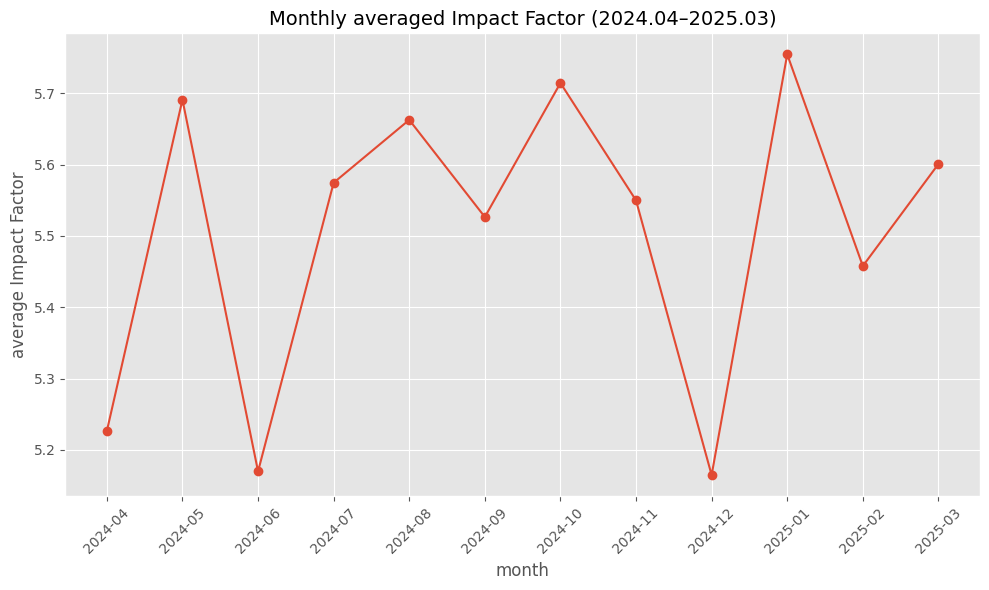

In [21]:
#2024 그래프 그리기
# 선그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(monthly_if_2024["Month"].astype(str), monthly_if_2024["Average_JIF"], marker='o')

# 제목 및 축 레이블 설정
plt.title("Monthly averaged Impact Factor (2024.04–2025.03)", fontsize=14)
plt.xlabel("month", fontsize=12)
plt.ylabel("average Impact Factor", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

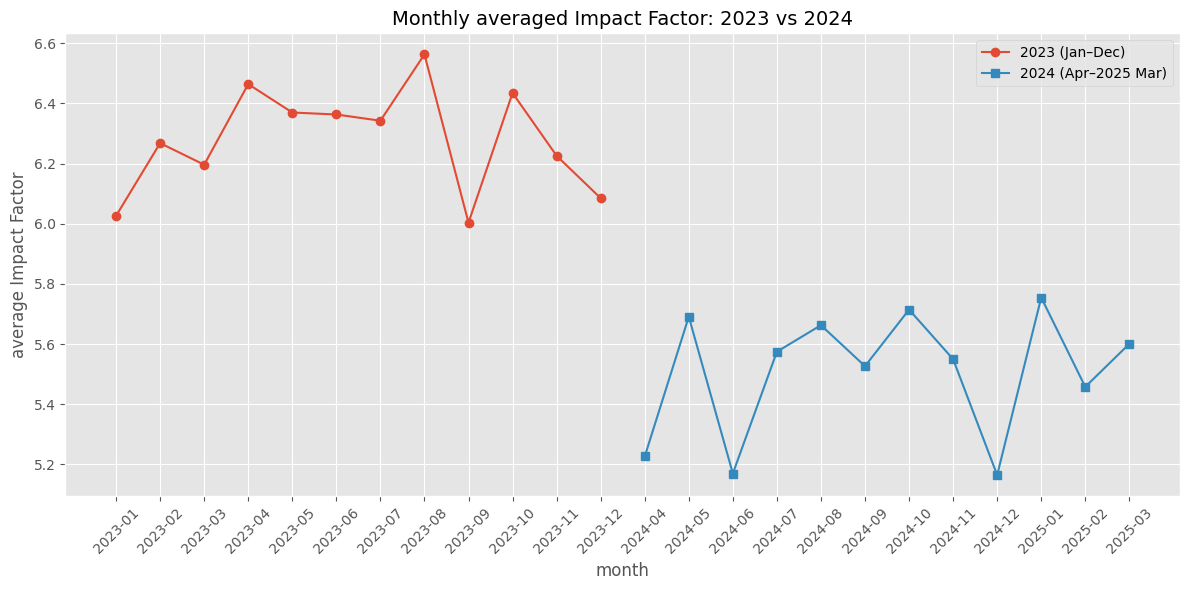

In [29]:
# 그래프 그리기
plt.figure(figsize=(12, 6))

# 2023년 데이터 선
plt.plot(
    monthly_if_2023["Month"].astype(str),
    monthly_if_2023["Average_JIF"],
    marker='o',
    label="2023 (Jan–Dec)"
)

# 2024년 데이터 선
plt.plot(
    monthly_if_2024["Month"].astype(str),
    monthly_if_2024["Average_JIF"],
    marker='s',
    label="2024 (Apr–2025 Mar)"
)

# 제목 및 축 레이블
plt.title("Monthly averaged Impact Factor: 2023 vs 2024", fontsize=14)
plt.xlabel("month", fontsize=12)
plt.ylabel("average Impact Factor", fontsize=12)
plt.xticks(rotation=45)

# 범례 추가
plt.legend()

# 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()

In [25]:
#정규성 검정을 위한 샤피로 윌크 검정

from scipy.stats import shapiro
from scipy.stats import ttest_ind

jif_2023 = monthly_if_2023["Average_JIF"].dropna()
jif_2024 = monthly_if_2024["Average_JIF"].dropna()

stat_2023, p_2023 = shapiro(jif_2023)
stat_2024, p_2024 = shapiro(jif_2024)

print("📊 Shapiro-Wilk Test Results")
print(f"2023 평균 IF 정규성 검정: W={stat_2023:.4f}, p={p_2023:.4f}")
print(f"2024 평균 IF 정규성 검정: W={stat_2024:.4f}, p={p_2024:.4f}")

# 해석 예시
if p_2023 > 0.05:
    print("✔️ 2023 데이터는 정규성을 만족합니다.")
else:
    print("⚠️ 2023 데이터는 정규성이 없습니다.")

if p_2024 > 0.05:
    print("✔️ 2024 데이터는 정규성을 만족합니다.")
else:
    print("⚠️ 2024 데이터는 정규성이 없습니다.")


📊 Shapiro-Wilk Test Results
2023 평균 IF 정규성 검정: W=0.9611, p=0.7996
2024 평균 IF 정규성 검정: W=0.8707, p=0.0667
✔️ 2023 데이터는 정규성을 만족합니다.
✔️ 2024 데이터는 정규성을 만족합니다.


In [28]:
# t-test
t_stat, p_val = ttest_ind(jif_2023, jif_2024, equal_var=False)
print("독립표본 t-test (Welch)")
print(f"t = {t_stat:.4f}, p = {p_val:.4f}")



독립표본 t-test (Welch)
t = 9.6861, p = 0.0000


t-test p-value <0.05 이하이므로 등분산 가정인 귀무가설 기각 가능... 유의미한 평균차이가 있음을 알 수 있음...